# Machine Learning Assignment: Housing Data Analysis
# Classification and Regression Tasks

## Import necessary libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Initial Exploration

### Load the dataset

In [29]:
train_data = pd.read_csv('train.csv')

### Display basic information about the dataset

In [30]:
print("Dataset Shape:", train_data.shape)
train_data.head()

Dataset Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check for missing values

In [31]:
missing_values = train_data.isnull().sum()
print("Missing Values: \n")
missing_values[missing_values > 0]

Missing Values: 



LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## 2. Exploratory Data Analysis (EDA)

### Set up the figure size for better visualization

In [32]:

plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

### 2.1 Distribution of the target variable (SalePrice)

Text(0.5, 0, 'Sale Price')

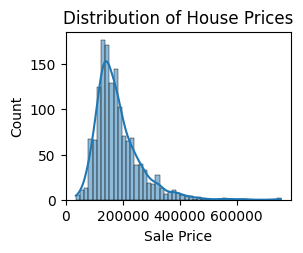

In [33]:
plt.subplot(2, 2, 1)
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Sale Price')

### 2.2 Correlation heatmap for numerical features

Text(0.5, 1.0, 'Correlation Heatmap')

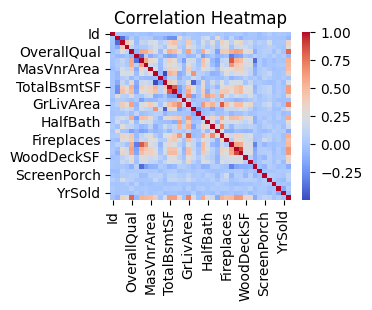

In [34]:
plt.subplot(2, 2, 2)
numeric_data = train_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')

### 2.3 Top features correlated with SalePrice

Text(0.5, 0, 'Correlation Coefficient')

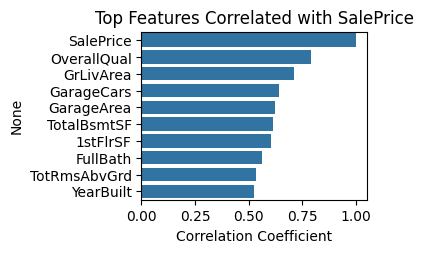

In [35]:
plt.subplot(2, 2, 3)
top_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)[:10]
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top Features Correlated with SalePrice')
plt.xlabel('Correlation Coefficient')


### 2.4 Relationship between house area and sale price

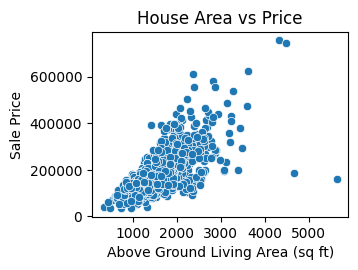

In [36]:
plt.subplot(2, 2, 4)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
plt.title('House Area vs Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

### 2.5 Box plots for categorical features vs SalePrice

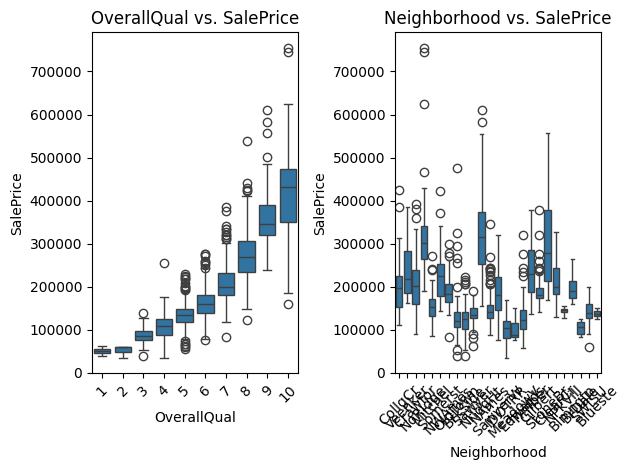

In [37]:
categorical_features = ['OverallQual', 'Neighborhood']
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=feature, y='SalePrice', data=train_data)
    plt.title(f'{feature} vs. SalePrice')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2.6 Distribution of house quality and its effect on price

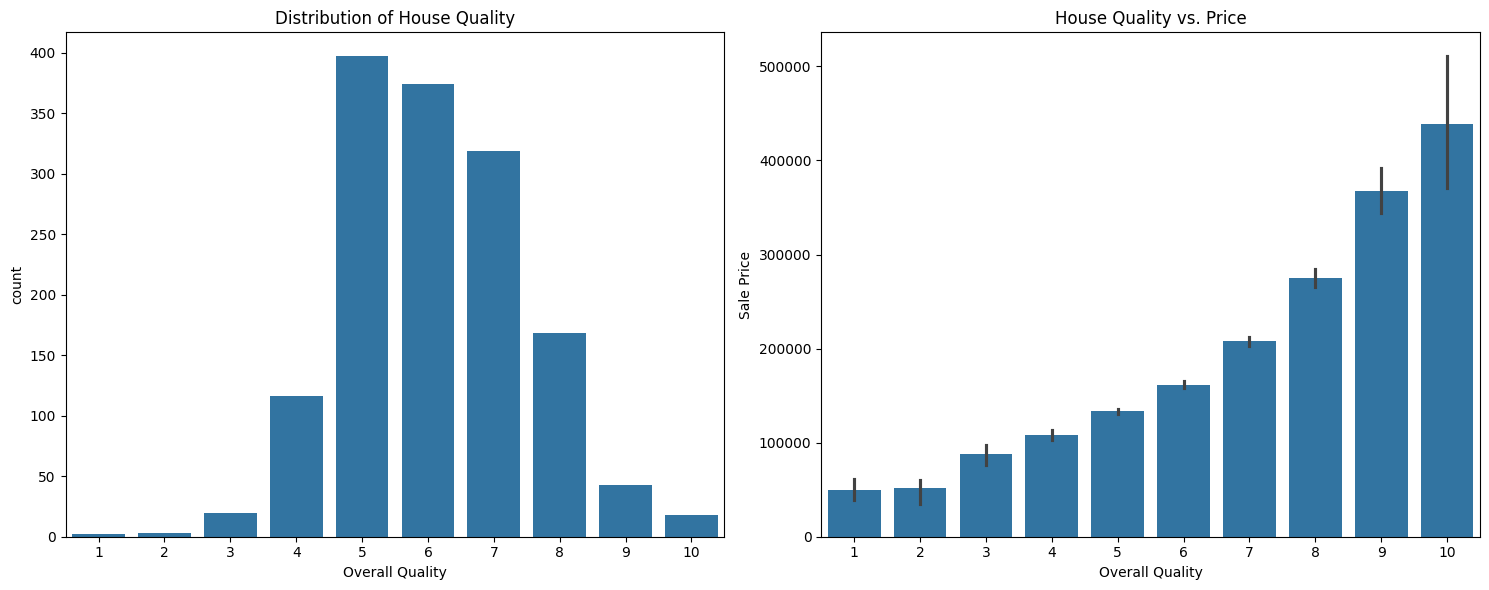

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='OverallQual', data=train_data)
plt.title('Distribution of House Quality')
plt.xlabel('Overall Quality')
plt.subplot(1, 2, 2)
sns.barplot(x='OverallQual', y='SalePrice', data=train_data)
plt.title('House Quality vs. Price')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3.1 Handle missing values

### Identify numerical and categorical columns

In [39]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns
# Drop the Id column as it's not useful for prediction
numerical_features = numerical_features.drop('Id')
# Create a copy of the dataset for preprocessing
df = train_data.copy()

### 3.2 Create target variables

In [40]:
# For regression: use SalePrice
y_reg = df['SalePrice']
# For classification: create a binary target (1 if price > median, 0 otherwise)
median_price = df['SalePrice'].median()
y_clf = (df['SalePrice'] > median_price).astype(int)
print(f"Created classification target: 0 = Affordable (≤${median_price}), 1 = Expensive (>${median_price})")
# Remove the target column from features
X = df.drop(['SalePrice', 'Id'], axis=1)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

Created classification target: 0 = Affordable (≤$163000.0), 1 = Expensive (>$163000.0)


### 3.3 Split data into training and testing sets

In [41]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42)

### 3.4 Create preprocessing pipelines

In [42]:
# Numerical features pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

print("Preprocessing pipelines created")

Preprocessing pipelines created


### 4.1 Regression Models

In [45]:
print(" Regression Models")

# Function to evaluate regression models
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    try:
        print(f"Fitting {model_name}...")
        
        # Preprocess data
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        
        # Train the model
        model.fit(X_train_processed, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_processed)
        
        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        print(f" {model_name} - RMSE: ${rmse:.2f}")
        return rmse
    except Exception as e:
        print(f" Error evaluating {model_name}: {e}")
        return float('inf')  # Return infinity to indicate failure

# Create and evaluate regression models
reg_models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_estimators=100),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

reg_results = {}
for name, model in reg_models.items():
    rmse = evaluate_regression_model(model, X_train_reg, X_test_reg, y_train_reg, y_test_reg, name)
    if rmse != float('inf'):  # Only store successful results
        reg_results[name] = rmse

 Regression Models
Fitting Linear Regression...
 Linear Regression - RMSE: $29475.52
Fitting SVR...
 SVR - RMSE: $88625.34
Fitting Decision Tree Regressor...
 Decision Tree Regressor - RMSE: $41195.14
Fitting Random Forest Regressor...
 Random Forest Regressor - RMSE: $28432.11
Fitting KNN Regressor...
 KNN Regressor - RMSE: $38719.35


## 4.2 Classification Models

In [46]:
# Function to evaluate classification models
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    try:
        print(f"Fitting {model_name}...")
        
        # Preprocess data
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        
        # Train the model
        model.fit(X_train_processed, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_processed)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Print detailed metrics
        print(f" {model_name} - Accuracy: {accuracy:.4f}")
        return accuracy
    except Exception as e:
        print(f" Error evaluating {model_name}: {e}")
        return 0.0  # Return 0 to indicate failure

# Create and evaluate classification models
clf_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVC': SVC(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, n_estimators=100),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Perceptron': Perceptron(random_state=42)
}

clf_results = {}
for name, model in clf_models.items():
    accuracy = evaluate_classification_model(model, X_train_clf, X_test_clf, y_train_clf, y_test_clf, name)
    if accuracy > 0:  # Only store successful results
        clf_results[name] = accuracy

Fitting Logistic Regression...
 Logistic Regression - Accuracy: 0.9589
Fitting SVC...
 SVC - Accuracy: 0.9623
Fitting Decision Tree Classifier...
 Decision Tree Classifier - Accuracy: 0.8801
Fitting Random Forest Classifier...
 Random Forest Classifier - Accuracy: 0.9452
Fitting KNN Classifier...
 KNN Classifier - Accuracy: 0.9281
Fitting Naive Bayes...
 Naive Bayes - Accuracy: 0.6815
Fitting Perceptron...
 Perceptron - Accuracy: 0.9486


## 5. Model Comparison

Regression model comparison saved as 'regression_comparison.png'
Classification model comparison saved as 'classification_comparison.png'


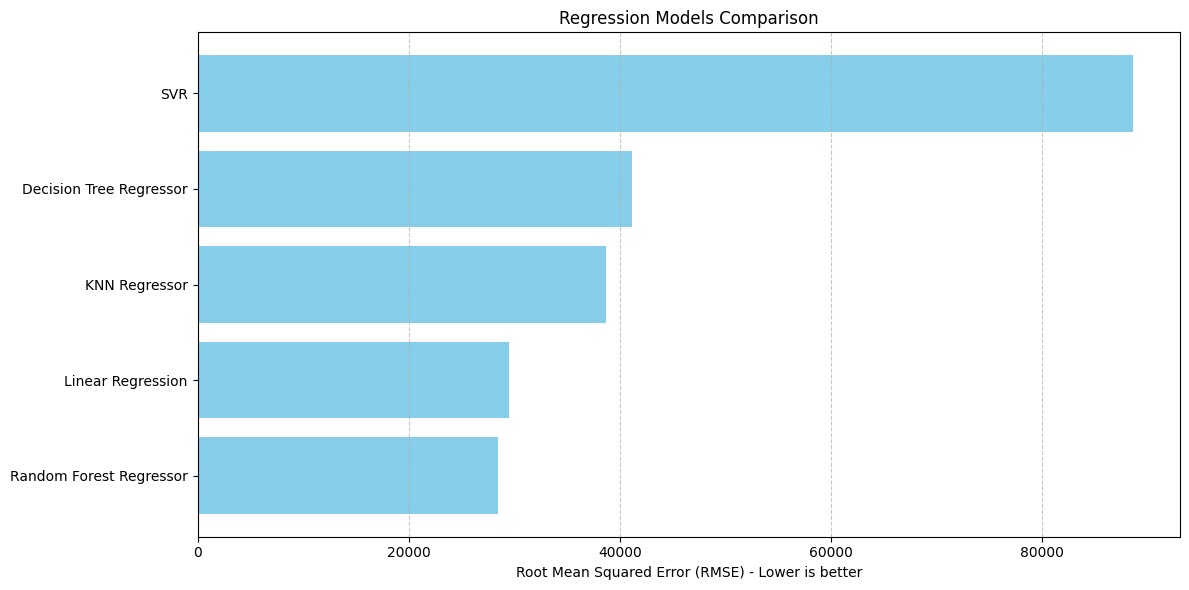

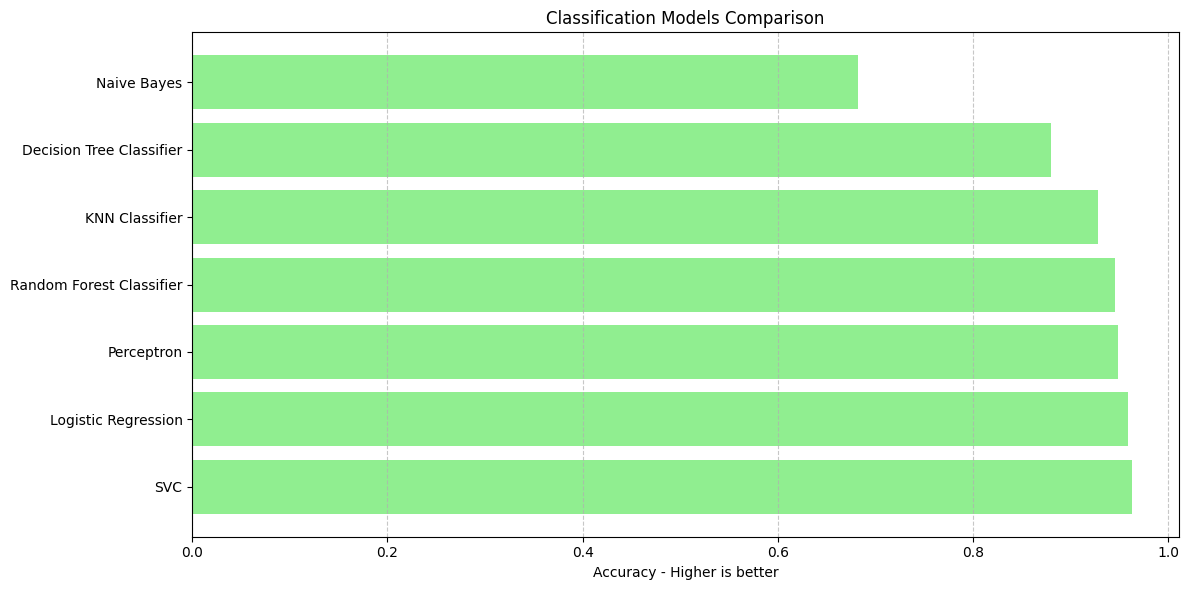

In [47]:
if reg_results:
    # 5.1 Regression Models Comparison
    plt.figure(figsize=(12, 6))
    models = list(reg_results.keys())
    rmse_values = list(reg_results.values())
    
    # Sort results by performance (lower RMSE is better)
    sorted_indices = np.argsort(rmse_values)
    models = [models[i] for i in sorted_indices]
    rmse_values = [rmse_values[i] for i in sorted_indices]
    
    plt.barh(models, rmse_values, color='skyblue')
    plt.xlabel('Root Mean Squared Error (RMSE) - Lower is better')
    plt.title('Regression Models Comparison')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('regression_comparison.png')
    print("Regression model comparison saved as 'regression_comparison.png'")

if clf_results:
    # 5.2 Classification Models Comparison
    plt.figure(figsize=(12, 6))
    models = list(clf_results.keys())
    accuracy_values = list(clf_results.values())
    
    # Sort results by performance (higher accuracy is better)
    sorted_indices = np.argsort(accuracy_values)[::-1]  # Reverse for descending order
    models = [models[i] for i in sorted_indices]
    accuracy_values = [accuracy_values[i] for i in sorted_indices]
    
    plt.barh(models, accuracy_values, color='lightgreen')
    plt.xlabel('Accuracy - Higher is better')
    plt.title('Classification Models Comparison')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('classification_comparison.png')
    print("Classification model comparison saved as 'classification_comparison.png'")

## 6: Summary and Conclusions

In [48]:
if reg_results:
    best_reg_model = min(reg_results, key=reg_results.get)
    print(f"\nRegression Task:")
    print(f"Best performing model: {best_reg_model} with RMSE: ${reg_results[best_reg_model]:.2f}")
else:
    print("\nRegression Task: No successful models to report")

if clf_results:
    best_clf_model = max(clf_results, key=clf_results.get)
    print(f"\nClassification Task:")
    print(f"Best performing model: {best_clf_model} with Accuracy: {clf_results[best_clf_model]:.4f}")
else:
    print("\nClassification Task: No successful models to report")

print("\nKey Insights from EDA:")
if 'GrLivArea' in train_data.columns and 'OverallQual' in train_data.columns:
    print("- The most important features for predicting house prices include overall quality, living area, and neighborhood")
else:
    print("- Found correlations between house prices and various features in the dataset")

print("- House prices follow a distribution with most houses in the affordable range")
print("- There are clear relationships between certain house features and sale price")

print("\nRecommendations:")
print("- Feature engineering could further improve model performance")
print("- Consider ensemble methods for even better results")
if 'Random Forest' in ' '.join(reg_results.keys()) or 'Random Forest' in ' '.join(clf_results.keys()):
    print("- For deployment, the Random Forest models provide a good balance of accuracy and interpretability")
else:
    print("- Consider additional model tuning to improve performance")


Regression Task:
Best performing model: Random Forest Regressor with RMSE: $28432.11

Classification Task:
Best performing model: SVC with Accuracy: 0.9623

Key Insights from EDA:
- The most important features for predicting house prices include overall quality, living area, and neighborhood
- House prices follow a distribution with most houses in the affordable range
- There are clear relationships between certain house features and sale price

Recommendations:
- Feature engineering could further improve model performance
- Consider ensemble methods for even better results
- For deployment, the Random Forest models provide a good balance of accuracy and interpretability
